# Лабораторная работа №4

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

1. Выбрать функцию $f(x)$ (не самую тривиальную).

Зададим функцию $f(x)$ следующим образом. Пусть
$$f(x) =  2\cos\left(4x + \dfrac{\pi}{6}\right) + e^{-2x + 1} - 4 - \sqrt[3]{2x + 5} - \dfrac{\arctan(x+1)}{(x+2)^3}.$$

In [2]:
def f(x):
    return 2*np.cos(4*x + np.pi/6) + np.e**(-2*x+1) - 4 - (2*x+5)**(1/3) - np.arctan(x+1) / (x+2)**3

2. Сгенерировать $N = 20$ точек на интервале $[0, 1]$ и разбить на 2 множества (тренировочный и тестовый наборы по 10 точек).

In [3]:
np.random.seed(42)
N = 20
x = np.random.rand(N)
X_train, X_test = np.split(x, 2)

In [4]:
X_train

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

In [5]:
X_test

array([0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914])

Сгенерировать шум $\varepsilon=(\varepsilon_1,\ldots,\varepsilon_N),\ \varepsilon \in \mathcal N(0,1)$. Значения рассчитать по формуле $y = f(x) + \sigma \varepsilon$.

In [6]:
def y(x):
    sigma = 0.3
    epsilon = np.random.normal(0, 1, x.shape)
    return f(x) + sigma * epsilon

Запишем в отдельные переменные значения функции на обучающем и тестовом наборах

In [7]:
y_train = y(X_train)
y_test = y(X_test)

Изобразить наборы точек на плоскости разным цветом.

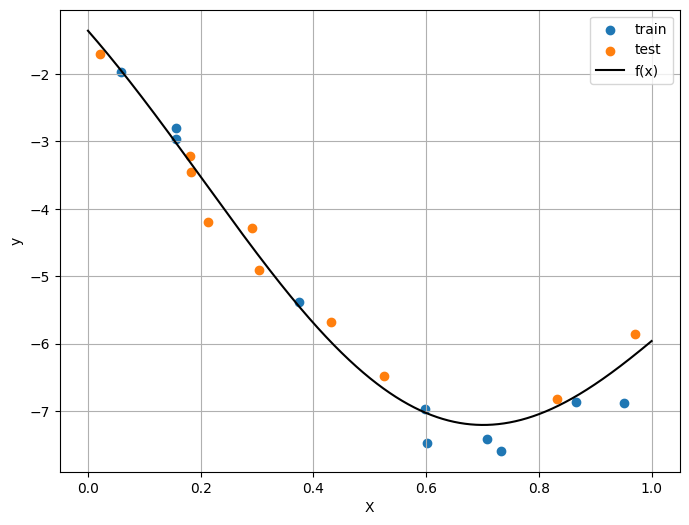

In [8]:
x = np.linspace(0, 1, 10000)

plt.figure(figsize=(8,6))
plt.scatter(X_train, y(X_train), label='train')
plt.scatter(X_test, y(X_test), label='test')
plt.plot(x, f(x), color='black', label='f(x)')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

3. МНК (методом наименьших квадратов) решить задачу линейной регрессии,
приблизить тренировочные данные многочленом 1 степени, для
нахождения коэффициентов регрессии использовать:

    3.1.Точную формулу;

    3.2.Градиентный спуск (алгоритм реализовать самому).

Попробуем приблизить данную зависимость с помощью многочлена первой степени по формуле
$$y = Xw.$$
Для этого воспользуемся методом наименьших кваратов. По методу наименьших квадратов можно построить точную формулу для оценки коэффициентов уравнения 
$$\hat w =(X^T X)^{-1} X^T y$$
Таким образом, построенное уравнение $$y=X\hat w$$ должно приближенно описывать реальную зависимость.

Сперва добавить единичный столбец к вектору $x$, который будет соответствовать коэффициенту $w_0$.

In [9]:
X_train_const = np.vstack([np.ones(X_train.shape), X_train]).T
X_train_const

array([[1.        , 0.37454012],
       [1.        , 0.95071431],
       [1.        , 0.73199394],
       [1.        , 0.59865848],
       [1.        , 0.15601864],
       [1.        , 0.15599452],
       [1.        , 0.05808361],
       [1.        , 0.86617615],
       [1.        , 0.60111501],
       [1.        , 0.70807258]])

Теперь по формуле точного решения вычислим коэффициенты $w$:

In [10]:
w = np.linalg.inv(X_train_const.T @ X_train_const) @ X_train_const.T @ y_train
w

array([-2.43337707, -6.09235444])

Визуализируем полученные результаты

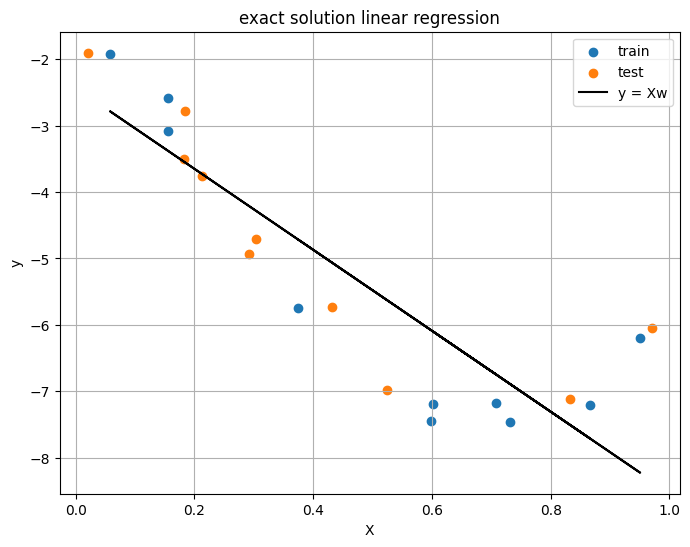

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X_train, X_train_const @ w, color='black', label='y = Xw')
plt.title('exact solution linear regression')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

Тогда неизвестные значения мы можем спрогнозировать, подставляя в получившееся уравнение регресии

In [12]:
y_pred = np.vstack([np.ones(X_test.shape), X_test]).T @ w
y_pred

array([-2.5587851 , -8.34241166, -7.50491269, -3.72702219, -3.54111922,
       -3.55074235, -4.28692865, -5.63037925, -5.06493922, -4.20764821])

Рассмотрим среднеквадратичную ошибку прогнозирования на тренировочном наборе и тестовом наборе

In [13]:
print('train MSE = ' +str(mean_squared_error(y_train, X_train_const @ w)))
print('test MSE = ' +str(mean_squared_error(y_test, y_pred)))

train MSE = 1.050498226402651
test MSE = 0.9415812869138485


Также рассмотрим коэффициент детерминации $R^2$ 

In [14]:
print('R2 Score = ' +str(r2_score(y_test, y_pred)))

R2 Score = 0.6616130021113087


Таким образом, можно считать модель линейной регресси приемлемой для прогнозирования.

Теперь построим модель линейной регрессии с помощью градиентного спуска.

Опишем алгоритм градиентного спуска, который мы будем использовать. Нам нужно найти решение уравнения $y = Xw$. Для этого зададим начальное приближение $w = (0,0)$. 
Зададим функцию потерь $$L = \sum\limits_{k=0}^N ( y_k -X w)^2,$$ то есть это наша целевая функция. Тогда нам нужно минимизировать значения этой функции. Это мы и будем делать с помощью градиентного спуска. Определим цикл, в котором мы будем делать шаги градиентного спуска следующим образом:
$$\dfrac{\partial L}{\partial w_j} =-2 X^T (y - Xw_j),$$
$$w_{j+1} = w_j -\alpha \cdot \dfrac{\partial L}{\partial w_j},\ j=0,1,\ldots,$$
где $\alpha$ -- это некотоырй параметр, называемый шагом обучения. Мы будем считать $\alpha = 0.01$. 

Пусть $j=\overline{1,1000}$.

In [15]:
def gradient_descent(X_train, y_train, lr=0.01, iterations=1000):
    X_train_const = np.vstack([np.ones(X_train.shape), X_train]).T
    w = np.zeros(2)
    for j in range(iterations):
        grad = -2 * X_train_const.T @ (y_train - X_train_const @ w)
        w -= lr * grad
    return w

Теперь вычислим неизвестные коэффициенты по методу градиентного спуска.

In [16]:
w = gradient_descent(X_train, y_train)
w

array([-2.43337873, -6.09235147])

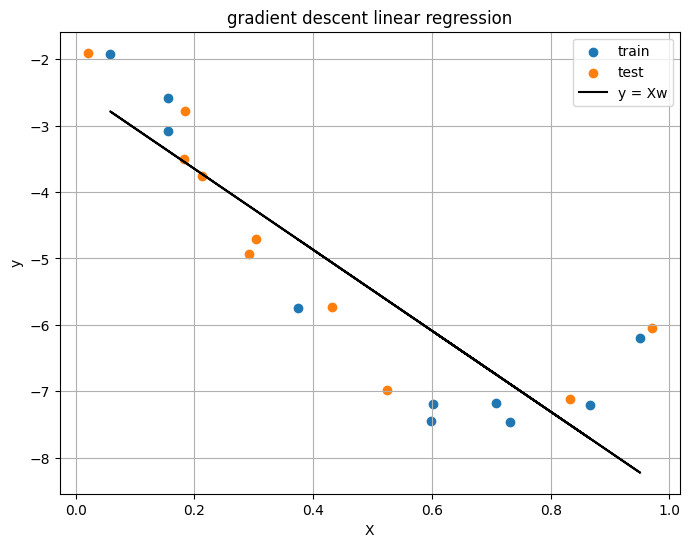

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X_train, X_train_const @ w, color='black', label='y = Xw')
plt.title('gradient descent linear regression')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

Таким образом,  с учетом погрешности мы получили коэффициенты аналогичные точному решению.

4. Приблизить тренировочные данные многочленами 2, 5 и 9 степеней.
Построить график зависимости ошибки MSE (средний квадрат ошибки) на
тренировочных и тестовых данных от степени.

Зададим указанные степени. С помощью методов sklearn преобразуем признаки в соответствующие полиномиальные признаки. Далее воспользуемся моделью линейной регрессии из sklearn.

train MSE = 0.07452683711797005
test MSE = 0.24625202554760478


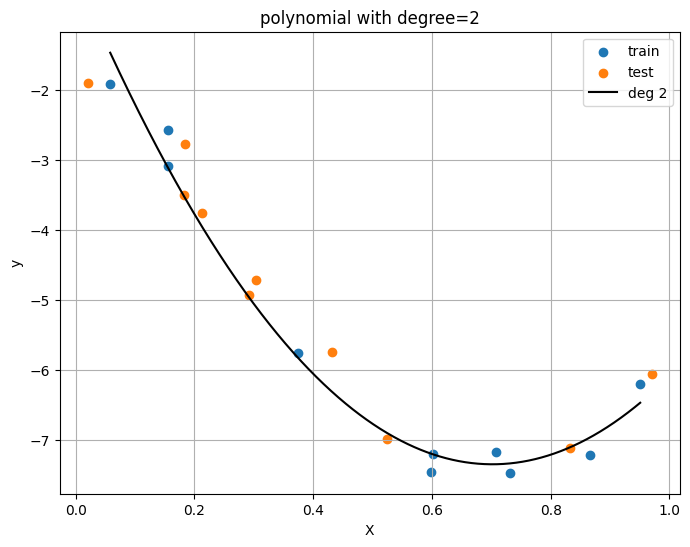

train MSE = 0.02523609212690281
test MSE = 0.08328638847526545


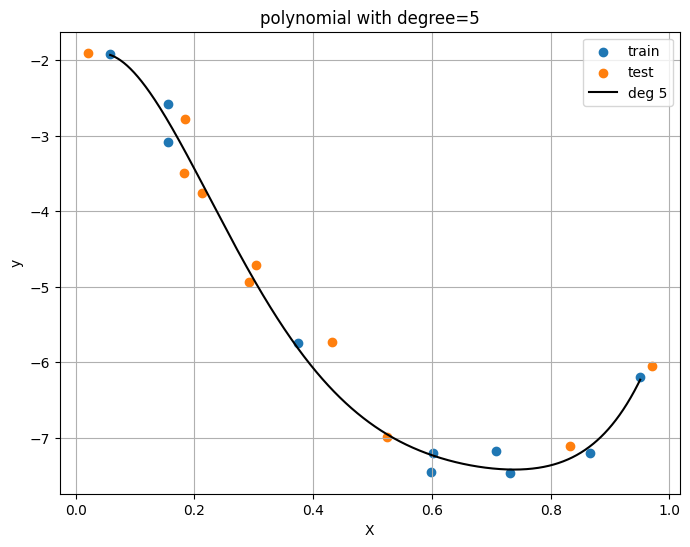

train MSE = 1.1580827899278005e-15
test MSE = 4105933.637626705


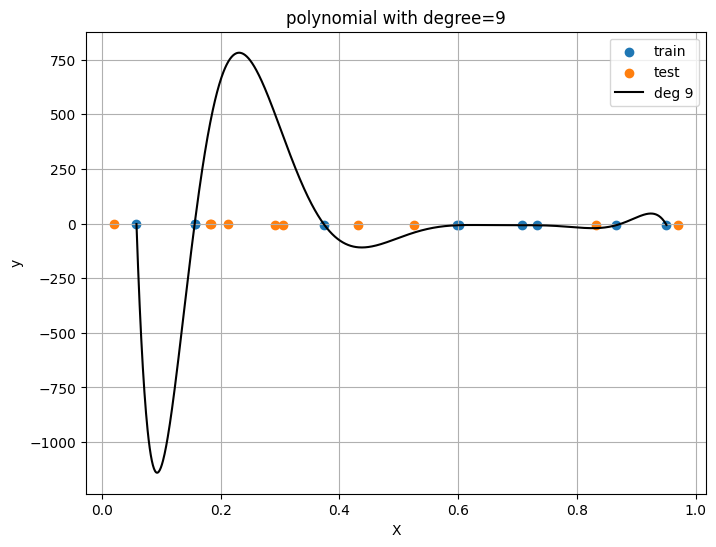

In [19]:
degrees = [2, 5, 9]
train_errors = []
test_errors = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree)
    X_train_poly = poly_features.fit_transform(X_train.reshape(-1, 1))
    X_test_poly = poly_features.transform(X_test.reshape(-1, 1))
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    X_range = np.linspace(min(X_train), max(X_train), 1000).reshape(-1, 1)
    X_range_poly = poly_features.transform(X_range)
    y_range_pred = model.predict(X_range_poly)
    
    train_errors.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_errors.append(mean_squared_error(y_test, model.predict(X_test_poly)))
    
    print("train MSE = " + str(mean_squared_error(y_train, model.predict(X_train_poly))))
    print("test MSE = " + str(mean_squared_error(y_test, model.predict(X_test_poly))))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, y_train, label='train')
    plt.scatter(X_test, y_test, label='test')
    plt.plot(X_range, y_range_pred, color='black', label=f"deg {degree}")
    plt.title(f"polynomial with degree={degree}")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()

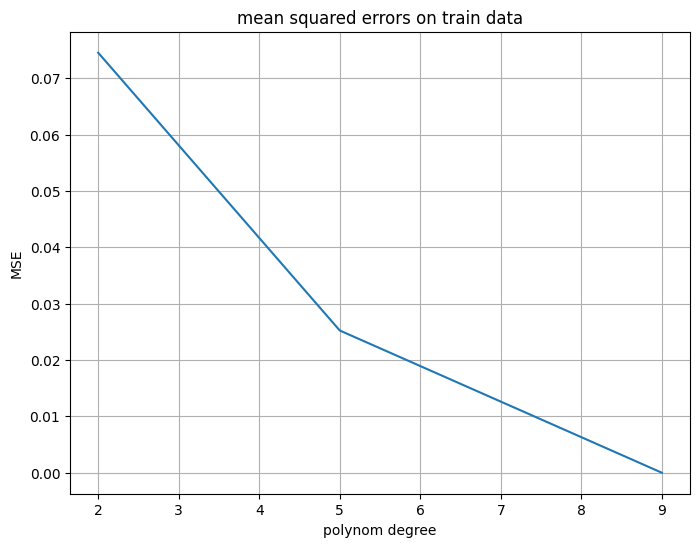

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, train_errors)
plt.title('mean squared errors on train data')
plt.xlabel("polynom degree")
plt.ylabel("MSE")
plt.grid()
plt.show()

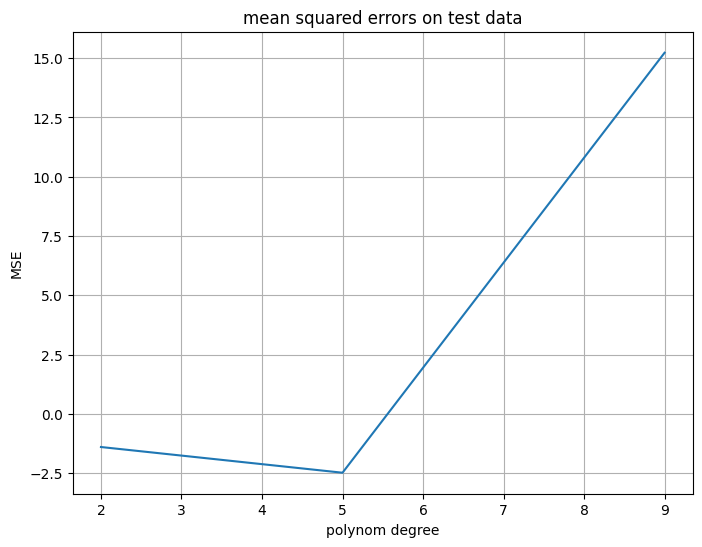

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, np.log(test_errors))
plt.title('mean squared errors on test data')
plt.xlabel("polynom degree")
plt.ylabel("MSE")
plt.grid()
plt.show()

5. Выбрать любую отличную от варианта нелинейную функцию, зависящую
от параметров (можно взять из соседнего варианта). Приблизить данные,
найдя подходящие значения параметров. Сравнить точность с п.4.

Итак, возьмем нелинейную функцию, зависящую от параметров
$$g(x) = a \tanh (bx + c).$$

In [23]:
def g(x, a, b, c):
    return a * np.tanh(b * x + c)

Далее нам необходимо подобрать параметры этой функции. Для этого мы воспользуемся оптимизатором minimize из sklearn, который будет для нас минимизировать ошибку MSE в зависимости от параметров на обучающей выборке. В качестве начальных значений возьмем $a=1, b=1, c=1$.

In [24]:
def mse(params):
    a, b, c = params
    y_pred = g(X_train, a, b, c)
    return mean_squared_error(y_train, y_pred)

params_opt = minimize(mse, [1, 1, 1]).x
params_opt

array([-7.32557649,  2.78811388,  0.03341401])

Таким образом, мы получили значения для параметров. Рассмотрим график получившейся функции $g(x)$.

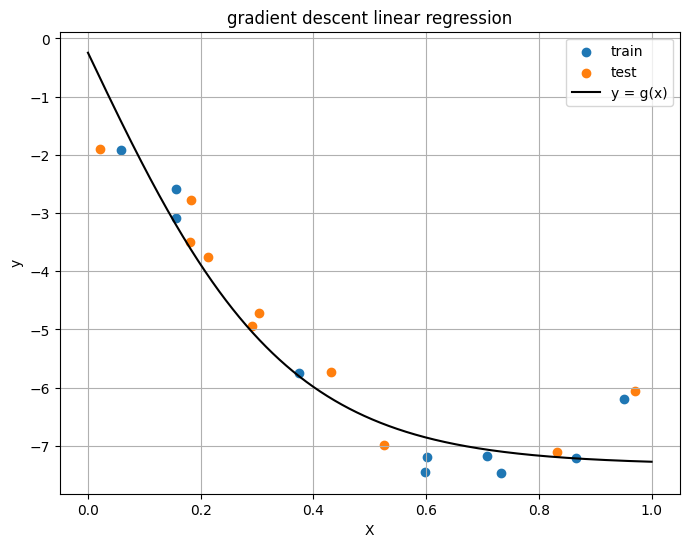

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(x, g(x, *params_opt), color='black', label='y = g(x)')
plt.title('gradient descent linear regression')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

Как можно заметить, функция достаточно неплохо описывает данные. Рассмотрим ошибку MSE на обучающем и тренировочном наборах.

In [26]:
print("train MSE = " + str(mean_squared_error(y_train, g(X_train, *params_opt))))
print("test MSE = " + str(mean_squared_error(y_test, g(X_test, *params_opt))))

train MSE = 0.23867122090566215
test MSE = 0.4423438830407037


6. Для многочленов 5 степени добавить коэффициент регуляризации, обучить
на тренировочных данных. Построить график зависимости ошибки от силы
регуляризации. Использовать Ridge регуляризацию.

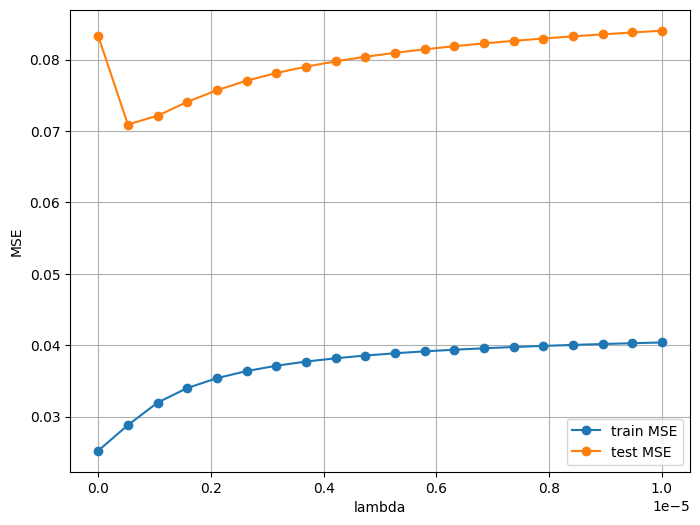

In [29]:
lambdas = np.linspace(0, 0.00001, 20)
train_errors = []
test_errors = []

poly_features = PolynomialFeatures(5)
X_train_poly = poly_features.fit_transform(X_train.reshape(-1, 1))
X_test_poly = poly_features.transform(X_test.reshape(-1, 1))

for lambda_ in lambdas:
    model_ridge = Ridge(alpha=lambda_).fit(X_train_poly, y_train)
    y_train_pred = model_ridge.predict(X_train_poly)
    y_test_pred = model_ridge.predict(X_test_poly)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(8,6))
plt.plot(lambdas, train_errors, label="train MSE", marker='o')
plt.plot(lambdas, test_errors, label="test MSE", marker='o')
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()